# Introduction

### To load dataset:
- Click Add Input
- Seach "I'm Something of a Painter"
- Click first result

Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import numpy as np
import os
from PIL import Image

### Create Dataset Class

In [ ]:
!kaggle competitions download -c gan-getting-started
!unzip gan-getting-started.zip

Streaming output truncated to the last 5000 lines.
  inflating: photo_jpg/46e84039a1.jpg  
  inflating: photo_jpg/46f391abec.jpg  
  inflating: photo_jpg/46f5ef1042.jpg  
  inflating: photo_jpg/4706619607.jpg  
  inflating: photo_jpg/4707b03a08.jpg  
  inflating: photo_jpg/47100a9939.jpg  
  inflating: photo_jpg/471f4755b9.jpg  
  inflating: photo_jpg/472b351bc4.jpg  
  inflating: photo_jpg/472d5ac100.jpg  
  inflating: photo_jpg/4758e5dd4c.jpg  
  inflating: photo_jpg/4762bb79ef.jpg  
  inflating: photo_jpg/4778b13518.jpg  
  inflating: photo_jpg/4787b82d37.jpg  
  inflating: photo_jpg/478e07feaa.jpg  
  inflating: photo_jpg/478eb12a82.jpg  
  inflating: photo_jpg/479698b371.jpg  
  inflating: photo_jpg/4796d67f61.jpg  
  inflating: photo_jpg/47aad493bd.jpg  
  inflating: photo_jpg/47ae0edd23.jpg  
  inflating: photo_jpg/47b94957ff.jpg  
  inflating: photo_jpg/47bb43fe3e.jpg  
  inflating: photo_jpg/47bb59d449.jpg  
  inflating: photo_jpg/47d391d94b.jpg  
  inflating: photo_jpg/47df26

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

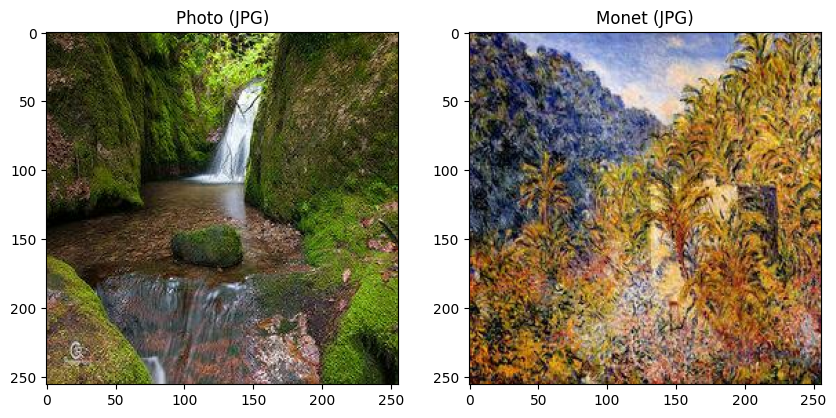

In [ ]:

# Define paths
photo_jpg_path = "/content/photo_jpg"
monet_jpg_path = "/content/monet_jpg"

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        #connects to the directory
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Scale to [-1, 1]
])

# Load datasets
photo_jpg_dataset = CustomImageDataset(root_dir=photo_jpg_path, transform=transform)
monet_jpg_dataset = CustomImageDataset(root_dir=monet_jpg_path, transform=transform)

# Create dataloaders
# batch_size is how ever many we want to process per iteration
# shuffle = true to prevent overfitting
photo_jpg_loader = DataLoader(photo_jpg_dataset, batch_size=32, shuffle=True, num_workers=4, prefetch_factor=2, pin_memory=True)
monet_jpg_loader = DataLoader(monet_jpg_dataset, batch_size=16, shuffle=True, num_workers=4, prefetch_factor=2, pin_memory=True)

# Function to convert tensor to image for visualization
def tensor_to_image(tensor):
    """
    Converts a normalized tensor to a PIL image.
    Args:
        tensor: A tensor in the range [-1, 1].
    Returns:
        A numpy array in the range [0, 1].
    """
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C)
    image = tensor * 0.5 + 0.5  # Rescale to [0, 1]
    return image.numpy()

# Get one example from each dataset
photo_batch = next(iter(photo_jpg_loader))
monet_batch = next(iter(monet_jpg_loader))
example_photo = photo_batch[0]
example_monet = monet_batch[0]

# Visualize the examples
plt.figure(figsize=(10, 5))

# Photo example
plt.subplot(121)
plt.title('Photo (JPG)')
plt.imshow(tensor_to_image(example_photo))

# Monet example
plt.subplot(122)
plt.title('Monet (JPG)')
plt.imshow(tensor_to_image(example_monet))

plt.show()

# Generator Model

### Overview:

- The generator starts off with random noise and gradually upscales it to the required size (256x256) to create an image.
- Each layer will double the image size and reducing the feature maps.
- The final layer produces a 3-channel RGB image.
- Pixel values are scaled between -1 and 1.


In [ ]:
# Image-to-Image (IRL-to-Monet) Generator

# Take an image
# Downsample the upsample

class Generator(nn.Module):
  def __init__(self, img_channels=3, feature_maps=64):
    super(Generator, self).__init__()

    # downsampling
    # reduce the spacial dimensions and increase the depth (features)
    self.down1 = self.conv_block(img_channels, feature_maps, kernel_size=7, stride=1)  # 256x256 → 256x256
    self.down2 = self.conv_block(feature_maps, feature_maps * 2, kernel_size=3, stride=2)  # 256x256 → 128x128
    self.down3 = self.conv_block(feature_maps * 2, feature_maps * 4, kernel_size=3, stride=2)  # 128x128 → 64x64
    self.down4 = self.conv_block(feature_maps * 4, feature_maps * 8, kernel_size=3, stride=2)  # 64x64 → 32x32

    # residual blocks
    # preserve and refine the details while maintaining the desired img style
    self.res_blocks = nn.Sequential(
        *[self.residual_block(feature_maps * 8) for _ in range(9)])
    # this refines things like "brush strokes" and retains integrity of the image

    # upsampling
    # convert the 256x64x64 feature maps back to 3x256x256
    self.up1 = self.upconv_block(feature_maps * 8, feature_maps * 4)  # 32x32 → 64x64
    self.up2 = self.upconv_block(feature_maps * 4, feature_maps * 2)  # 64x64 → 128x128
    self.up3 = self.upconv_block(feature_maps * 2, feature_maps)  # 128x128 → 256x256
    self.up4 = nn.Conv2d(feature_maps, img_channels, kernel_size=7, stride=1, padding=3)  # Keep same size
    # normalize the output to match real Monet paintings for more
    # efficient learning
    self.tanh = nn.Tanh()

  def conv_block(self, in_channels, out_channels, kernel_size, stride):
      return nn.Sequential(
          nn.ReflectionPad2d(1),  # Use reflection padding
          nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=0),
          nn.ReLU(inplace=True),
          nn.InstanceNorm2d(out_channels)
      )

  def upconv_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.InstanceNorm2d(out_channels)
    )


  def residual_block(self, in_channels):
      return nn.Sequential(
          nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
          nn.InstanceNorm2d(in_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
          nn.InstanceNorm2d(in_channels),
      )

  def forward(self, x):
      x = self.down1(x)
      x = self.down2(x)
      x = self.down3(x)
      x = self.down4(x)
      x = self.res_blocks(x)
      x = self.up1(x)
      x = self.up2(x)
      x = self.up3(x)
      x = self.up4(x)
      x = self.tanh(x)
      return x

# Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Creates layers to downsample the image
        self.down1 = self.downsample(3, 64, 4, normalize=False)
        self.down2 = self.downsample(64, 128, 4)
        self.down3 = self.downsample(128, 256, 4)

        # Zero padding to prepare for convolutional layer
        self.zero_pad1 = nn.ZeroPad2d(1)  # (bs, 34, 34, 256)
        # Processes the feature map with convolutional layer
        self.conv = nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0, bias=False)  # (bs, 31, 31, 512)
        self.norm1 = nn.InstanceNorm2d(512)


        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)

        # Final zero padding and convolutional layer
        self.zero_pad2 = nn.ZeroPad2d(1)  # (bs, 33, 33, 512)
        self.last = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)  # (bs, 30, 30, 1)


    def downsample(self, in_channels, out_channels, kernel_size, normalize=True):
        """Helper function to create a downsample block."""
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1, bias=False))
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)
    #Forward method applys all the layers
    def forward(self, x):
        # Apply downsample blocks
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)

        # Apply zero padding and convolutional layers
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.norm1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        # Apply final zero padding and convolutional layer
        x = self.zero_pad2(x)
        x = self.last(x)
        return x

# Training Loop

In [ ]:
print(torch.cuda.is_available())  # True if a GPU is available
print(torch.cuda.get_device_name(0))  # Show the GPU model

True
Tesla T4


TPU Setup

In [ ]:
# !pip uninstall -y tensorflow
# !pip install tensorflow-cpu

In [ ]:
# !curl -L https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
# # TPU Setup:

# import torch
# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.utils.serialization as xser
# import torch.multiprocessing as mp

# def _mp_fn(rank):
#     """Function for distributed training on TPU cores."""
#     device = xm.xla_device()

#     # Initialize model with XLA wrapper
#     generator = xmp.MpModelWrapper(Generator()).to(device)
#     discriminator = xmp.MpModelWrapper(Discriminator()).to(device)

#     # Prepare data loader with distributed sampler
#     train_sampler = torch.utils.data.distributed.DistributedSampler(
#         train_dataset, num_replicas=xm.xrt_world_size(), rank=xm.get_ordinal()
#     )
#     train_loader = torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

#     para_loader = pl.ParallelLoader(train_loader, [device])

#     # Training loop
#     for epoch in range(EPOCHS):
#         xm.master_print(f"Epoch {epoch+1}/{EPOCHS} on TPU Core {rank}")

#         for batch in para_loader.per_device_loader(device):
#             # Move batch to TPU
#             real_images = batch.to(device)

#             # Train Generator and Discriminator
#             loss_G, loss_D = train_step(generator, discriminator, real_images)

#             # Optimize
#             xm.optimizer_step(optimizer_G, barrier=True)
#             xm.optimizer_step(optimizer_D, barrier=True)

#         xm.master_print(f"Epoch {epoch+1} completed on TPU Core {rank}")

#     save_images(generator, fixed_noise, epoch)

#     # Save Model
#     if xm.is_master_ordinal():
#         xser.save(generator.state_dict(), "generator.bin")
#         xser.save(discriminator.state_dict(), "discriminator.bin")

# def save_images(generator, fixed_noise, epoch):
#     if xm.is_master_ordinal():  # Only the main TPU process saves images
#         generator.eval()  # Set generator to evaluation mode
#         with torch.no_grad():
#             fake_images = generator(fixed_noise).cpu()  # Move to CPU for saving
#         vutils.save_image(fake_images, f"generated_epoch_.png", normalize=True)
#         print(f"Saved generated images")
#     generator.train()

In [ ]:
# if __name__ == "__main__":
#     # Launch training across 8 TPU cores
#     mp.spawn(_mp_fn, nprocs=8, start_method="fork")

Training Loop (GPU)

In [ ]:
# Assuming you have these defined
# Generator: generator
# Discriminator: discriminator

from itertools import cycle
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator()
discriminator = Discriminator()

generator = torch.nn.DataParallel(generator)
discriminator = torch.nn.DataParallel(discriminator)

generator.to(device)
discriminator.to(device)

# Optimizers (FOR GPU ONLY)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# TPU
# g_optimizer = torch.optim.AdamW(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function (Binary Cross Entropy for GAN training)
criterion = nn.BCEWithLogitsLoss()

l1_loss = nn.L1Loss()

# Convert tensor to image for visualization
def tensor_to_image(tensor):
    tensor = tensor.cpu().squeeze(0)  # Move to CPU & remove batch dim
    tensor = tensor.permute(1, 2, 0)  # Change shape to (H, W, C)
    image = tensor * 0.5 + 0.5  # Rescale from [-1, 1] to [0, 1]
    image = image.clamp(0, 1)  # Ensure values are in valid range
    return image.numpy()

photo_cycle = cycle(photo_jpg_loader)
monet_cycle = cycle(monet_jpg_loader)

#
photo_cycle = photo_jpg_loader
monet_cycle = monet_jpg_loader

# Training loop
epochs = 10
for epoch in range(epochs):
    # Pair real photos with Monet paintings for balanced training


    # for real_photos, real_monets in zip(photo_jpg_loader, monet_jpg_loader):
    #     real_photos, real_monets = real_photos.to(device), real_monets.to(device)
    for _ in range(len(photo_jpg_loader)): # SWITCH TO THIS ONE FOR HPC TRAINING
        real_photos = next(photo_cycle).to(device)
        real_monets = next(monet_cycle).to(device)
        batch_size = real_photos.size(0)


        # 1. Train Generator (G)
        # We're gonna train it twice, since it appears to be struggling!
        for _ in range(2):
          g_optimizer.zero_grad()
          fake_monets = generator(real_photos)  # Generate Monet-style images
          fake_preds = discriminator(fake_monets)  # Try to fool discriminator
          g_loss = criterion(fake_preds, torch.ones_like(fake_preds))  # We want it to be classified as real
          g_loss.backward()
          g_optimizer.step()
          l1 = l1_loss(fake_monets, real_photos) * 10

        # 2. Train Discriminator (D)
        d_optimizer.zero_grad()

        # Train on real Monet paintings
        real_preds = discriminator(real_monets)
        real_loss = criterion(real_preds, torch.ones_like(real_preds))

        # Train on fake Monet images
        fake_preds = discriminator(fake_monets.detach())  # Detach so G isn't trained here
        fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))

        d_loss = (real_loss + fake_loss) / 2  # Average loss
        d_loss.backward()
        d_optimizer.step()

    # if ((epoch + 1) % 5 == 0): # BROKEN! PLEASE FIX
    # # Generate Monet-style image
    #     with torch.no_grad():
    #         generated_monet = generator(example_photo)

    #     # Plot results
    #     plt.figure(figsize=(10, 5))

    #     # Original photo
    #     plt.subplot(121)
    #     plt.title('Original Photo (Iteration #' + str(epoch + 1) + ')')
    #     plt.imshow(tensor_to_image(example_photo[0]))  # Remove batch dim for plotting
    #     plt.axis('off')

    #     # Generated Monet-style image
    #     plt.subplot(122)
    #     plt.title('Generated Monet (Iteration #' + str(epoch + 1) + ')')
    #     plt.imshow(tensor_to_image(generated_monet[0]))  # Remove batch dim for plotting
    #     plt.axis('off')

    #     plt.show()

    print(f"Epoch [{epoch+1}/{epochs}], G Loss: {g_loss.item():.4f}, D Loss: {d_loss.item():.4f}, L1 Loss: {l1.item():.4f}")


Epoch [1/10], G Loss: 0.7236, D Loss: 0.7260, L1 Loss: 6.7868
Epoch [2/10], G Loss: 0.6277, D Loss: 0.7270, L1 Loss: 7.2511
Epoch [3/10], G Loss: 0.7405, D Loss: 0.7179, L1 Loss: 7.8598
Epoch [4/10], G Loss: 0.7311, D Loss: 0.6941, L1 Loss: 6.8075
Epoch [5/10], G Loss: 0.7126, D Loss: 0.6943, L1 Loss: 7.3742
Epoch [6/10], G Loss: 0.6370, D Loss: 0.6915, L1 Loss: 7.0336
Epoch [7/10], G Loss: 0.7815, D Loss: 0.6246, L1 Loss: 7.1900
Epoch [8/10], G Loss: 0.7011, D Loss: 0.6507, L1 Loss: 9.9742
Epoch [9/10], G Loss: 0.9096, D Loss: 0.5158, L1 Loss: 8.3075
Epoch [10/10], G Loss: 0.9288, D Loss: 0.6489, L1 Loss: 9.9331


In [ ]:
import torch
import os
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
                                # Need to change directories around here
# Define paths
photo_folder = "/content/photo_jpg"  # Folder containing real photos
output_folder = "/kaggle/working/"  # Folder to save Monet-style images
os.makedirs(output_folder, exist_ok=True)

# Load trained generator (ensure it's in eval mode)
generator.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Ensure it matches training dimensions
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

def save_image(tensor, path):
    image = tensor.squeeze(0).detach().cpu().numpy()
    image = (image * 0.5 + 0.5) * 255  # Denormalize
    image = Image.fromarray(image.astype("uint8").transpose(1, 2, 0))
    image.save(path)

# Process each image in the folder
for image_name in tqdm(os.listdir(photo_folder)):
    image_path = os.path.join(photo_folder, image_name)
    output_path = os.path.join(output_folder, image_name)

    with torch.no_grad():
        input_image = preprocess_image(image_path).to('cuda' if torch.cuda.is_available() else 'cpu')
        generated_monet = generator(input_image)
        save_image(generated_monet, output_path)

print(f"Conversion complete. Monet-style images saved in {output_folder}")


  6%|▌         | 405/7038 [00:17<04:51, 22.79it/s]


KeyboardInterrupt: 